Camera Calibration with OpenCV
===

#### Compute the transformation between 3D object points in the world and 2D image points.
#### Run the code in the cell below to extract object points and image points for camera calibration.  

In [1]:
import numpy as np
import cv2
import glob
import pickle
from collections import deque
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from  matplotlib.pyplot import boxplot
%matplotlib inline

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Undistortion and Transformation
===

#### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration. 
#### Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

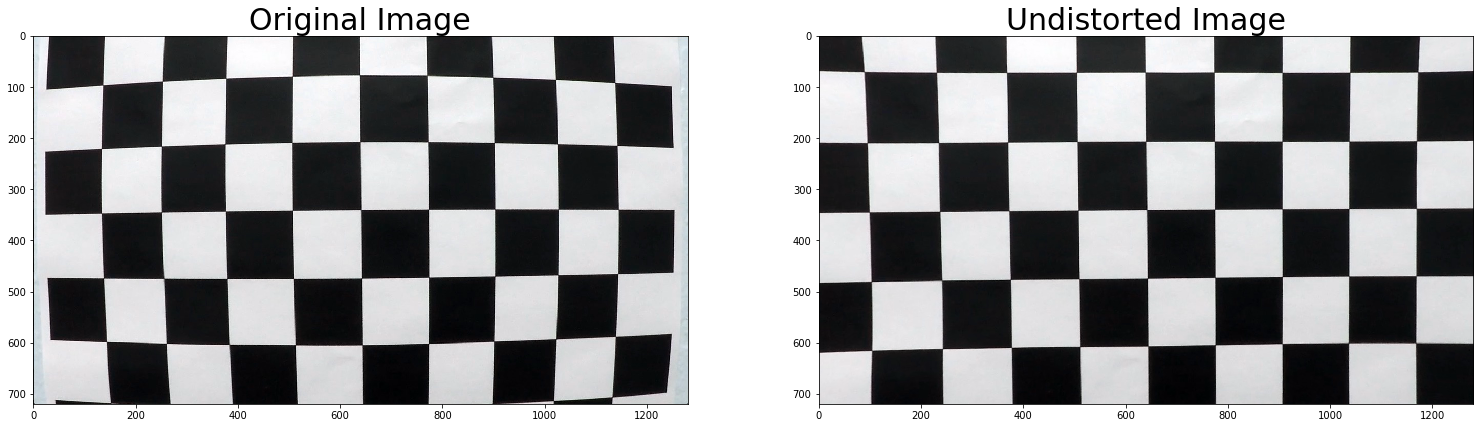

In [3]:
# Test undistortion on an image
image = cv2.imread('camera_cal/calibration1.jpg')
img_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration1_rev.jpg', dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration_wide_dist_pickle.p", "wb"))
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
name = 'undistorted'
plt.imsave('output_images/'+name+'.jpg', dst)

(720, 1280, 3)


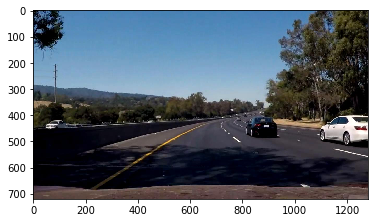

In [4]:
# Image imported
image = cv2.imread('test_images/test10.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(image.shape)

Perspective Transformation
===

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [6]:
def process_image(raw_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    input_image = np.copy(raw_image) # colored image
    # input_image = grayscale(raw_image) # gray scale

    # Apply Gaussian smoothing to reduce noise
    # Parameters: gaussian_blur(img, kernel_size)
    blur_image = gaussian_blur(input_image, 3) #17

    # Define our color selection critera
    red_threshold = 150
    green_threshold = 150
    blue_threshold = 255
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Drop the blue channel and set new threshold for red and green channels
    color_thresholds = (blur_image[:,:,0] < rgb_threshold[0]) \
             & (blur_image[:,:,1] < rgb_threshold[1]) \
             & (blur_image[:,:,2] < rgb_threshold[2])
    blur_image[color_thresholds] = [0,0,0]

    # Extract lines with Canny edge detection
    # parameters: canny(img, low_threshold, high_threshold)
    edge_image = canny(blur_image, 0, 50) #(60, 180), (70, 200), (100, 200)

    return edge_image

In [7]:
def corner_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    h, w = gray.shape[:2]
        
    # Define source and destination
    src = np.float32([(750. /1280.*w, 480. /720.*h),
                      (530. /1280.*w, 480. /720.*h),
                      (1130. /1280.*w, 720. /720.*h),
                      (190. /1280.*w, 720. /720.*h)])         
    dst = np.float32([(1100. /1280.*w, 0. /720.*h), 
                      (180. /1280.*w, 0. /720.*h), 
                      (1000. /1280.*w, 720. /720.*h), 
                      (190. /1280.*w, 720. /720.*h)])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
        
    return undist, warped, M, Minv, src, dst

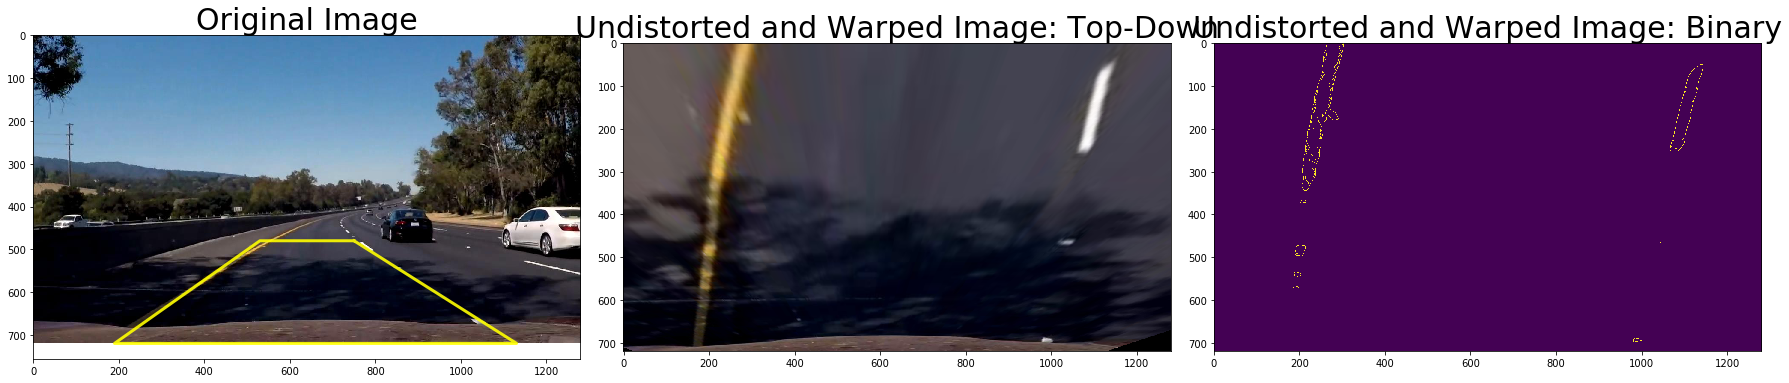

In [8]:
undist, top_down, perspective_M, Minv, src, dst = corner_unwarp(image, mtx, dist)
binary_birdeye = process_image(top_down)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
ax1.plot(x, y, color='#FFFF00', alpha=0.9, linewidth=3)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image: Top-Down', fontsize=30)
ax3.imshow(binary_birdeye)
ax3.set_title('Undistorted and Warped Image: Binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
name = 'bird_eye'
plt.imsave('output_images/'+name+'.jpg', top_down)

Edge Detection
===

#### Visualize Color Space Channels

In [9]:
def color_space_visualized(img):
    
    # Multiple color space channels
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    fig, axs = plt.subplots(4, 3, figsize=(20, 12))
    axs = axs.ravel()

    axs[0].axis('off')
    axs[0].imshow(img[:, :, 0])
    axs[0].set_title('RGB R-channel', fontsize=20)
    axs[1].axis('off')
    axs[1].imshow(img[:, :, 1])
    axs[1].set_title('RGB G-channel', fontsize=20)
    axs[2].axis('off')
    axs[2].imshow(img[:, :, 2])
    axs[2].set_title('RGB B-channel', fontsize=20)
    axs[3].axis('off')
    axs[3].imshow(img_HSV[:, :, 0])
    axs[3].set_title('HSV H-Channel', fontsize=20)
    axs[4].axis('off')
    axs[4].imshow(img_HSV[:, :, 1])
    axs[4].set_title('HSV S-channel', fontsize=20)
    axs[5].axis('off')
    axs[5].imshow(img_HSV[:, :, 2])
    axs[5].set_title('HSV V-Channel', fontsize=20)
    axs[6].axis('off')
    axs[6].imshow(img_HLS[:, :, 0])
    axs[6].set_title('HLS H-Channel', fontsize=20)
    axs[7].axis('off')
    axs[7].imshow(img_HLS[:, :, 1])
    axs[7].set_title('HLS L-channel', fontsize=20)
    axs[8].axis('off')
    axs[8].imshow(img_HLS[:, :, 2])
    axs[8].set_title('HLS S-Channel', fontsize=20)
    axs[9].axis('off')
    axs[9].imshow(img_LAB[:, :, 0])
    axs[9].set_title('LAB L-channel', fontsize=20)
    axs[10].axis('off')
    axs[10].imshow(img_LAB[:, :, 1])
    axs[10].set_title('LAB A-Channel', fontsize=20)
    axs[11].axis('off')
    axs[11].imshow(img_LAB[:, :, 2])
    axs[11].set_title('LAB B-Channel', fontsize=20)

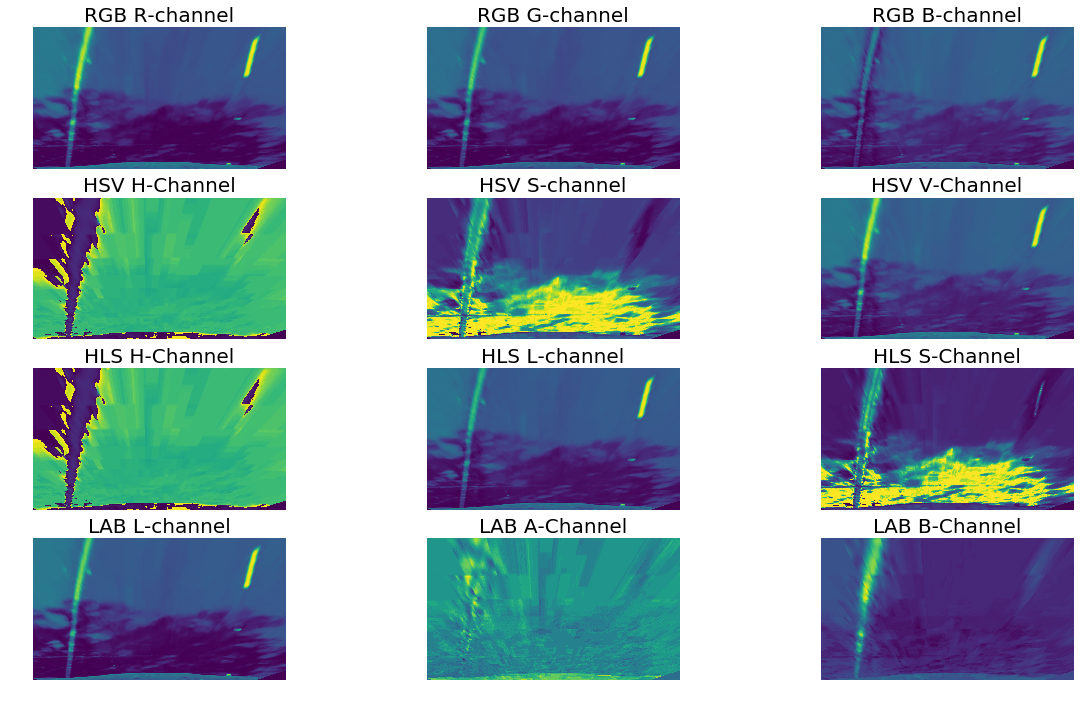

In [10]:
color_space_visualized(top_down)

#### Sobel Magnitude/Direction Threshold

In [11]:
def mag_dir_thresh(img, sobel_kernel=17, mag_thresh=(20, 134), dir_thresh=(0, 0.37)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute x and gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Calculate the direction of gradients
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag/255)
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_mag = np.zeros_like(gradmag)
    binary_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    binary_dir = np.zeros_like(graddir)
    binary_dir[(graddir >= dir_thresh[0]) & (graddir <= dir_thresh[1])] = 1  
    
    binary_output = np.zeros_like(binary_mag)
    binary_output[((binary_mag == 1) & (binary_dir == 1))] = 1
    
    return binary_output

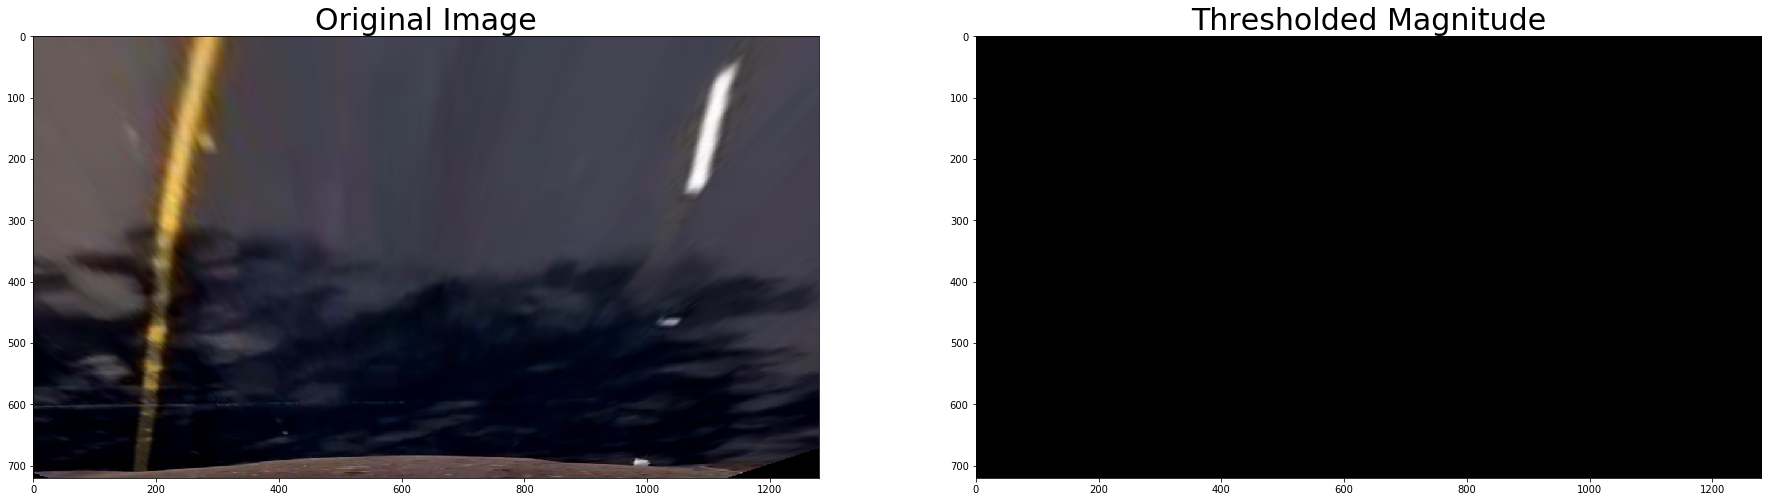

In [12]:
image = top_down

# Adjsut the sobel thresholds
def update_sobel(kernel, mag_min, mag_max, dir_min, dir_max):

    # Run the function
    mag_dir_binary = mag_dir_thresh(image, sobel_kernel=kernel, mag_thresh=(mag_min, mag_max), dir_thresh=(dir_min, dir_max))

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(mag_dir_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Interactive plot
interact(update_sobel, kernel=(1, 20, 2), 
                       mag_min=(0, 100), 
                       mag_max=(0, 255),
                       dir_min=(0, np.pi/2, 0.01), 
                       dir_max=(0, np.pi/2, 0.01))
print('')

#### Color Thresholding

In [13]:
def gray_thresh(img, thresh=(180, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

def RGB_thresh(img, thresh=(180, 255), channel=0):
    color_layer = img[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

def HSV_thresh(img, thresh=(15, 100), channel=0):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    color_layer = hsv[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

def HLS_thresh(img, thresh=(15, 100), channel=0):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_layer = hls[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

def LAB_thresh(img, thresh=(15, 100), channel=0):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    color_layer = lab[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

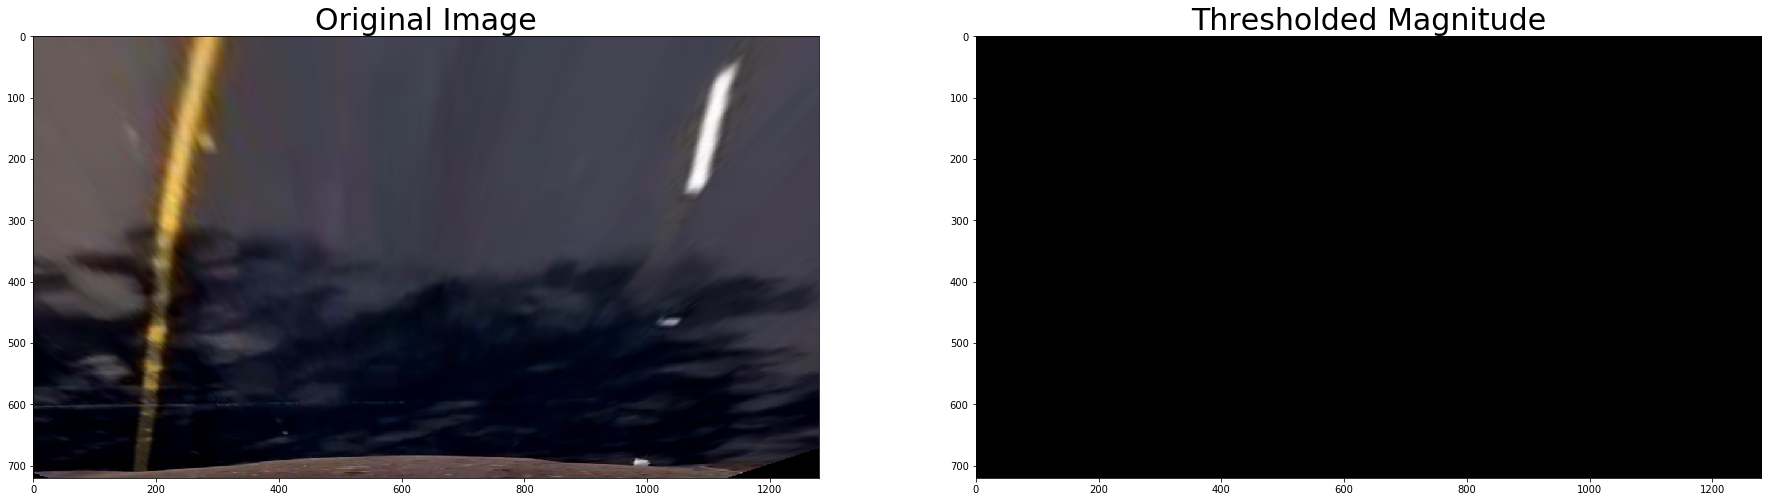

In [14]:
# Adjust the color thresholds
def update_color_thresh(function, min_thresh, max_thresh, channel):
    if function=='gray_thresh':
        color_binary = gray_thresh(image, (min_thresh, max_thresh)) 
    elif function=='RGB_thresh':
        color_binary = RGB_thresh(image, (min_thresh, max_thresh), channel)
    elif function=='HSV_thresh':
        color_binary = HSV_thresh(image, (min_thresh, max_thresh), channel)
    elif function=='HLS_thresh':
        color_binary = HLS_thresh(image, (min_thresh, max_thresh), channel)
    elif function=='LAB_thresh':
        color_binary = LAB_thresh(image, (min_thresh, max_thresh), channel)
        
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(color_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Interactive plot
interact(update_color_thresh, function='gray_thresh',
                              min_thresh=(0, 255), 
                              max_thresh=(0, 255),
                              channel=(0, 2, 1))
print('')    

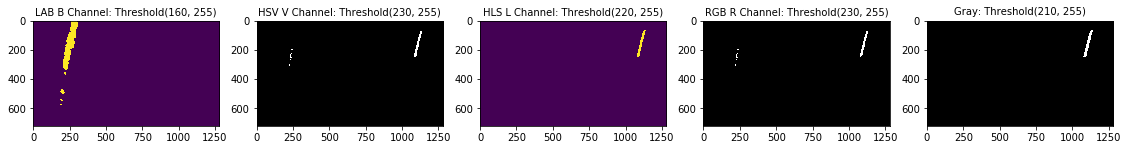

In [15]:
gray_binary = gray_thresh(top_down, thresh=(210, 255))
hsv_v_binary = HSV_thresh(top_down, thresh=(230, 255), channel=2)
hls_l_binary = HLS_thresh(top_down, thresh=(220, 255), channel=1)
rgb_r_binary = RGB_thresh(top_down, thresh=(230, 255), channel=0)
lab_b_binary = LAB_thresh(top_down, thresh=(160, 255), channel=2)

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 50))
ax1.imshow(lab_b_binary)
ax1.set_title('LAB B Channel: Threshold(160, 255)', fontsize=10)
ax2.imshow(hsv_v_binary, cmap='gray')
ax2.set_title('HSV V Channel: Threshold(230, 255)', fontsize=10)
ax3.imshow(hls_l_binary)
ax3.set_title('HLS L Channel: Threshold(220, 255)', fontsize=10)
ax4.imshow(rgb_r_binary, cmap='gray')
ax4.set_title('RGB R Channel: Threshold(230, 255)', fontsize=10)
ax5.imshow(gray_binary, cmap='gray')
ax5.set_title('Gray: Threshold(210, 255)', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  

### Image Processing Pipeline Setup

In [16]:
def image_process(img):
      
    # Undistortion and Transformation
    undist, top_down, perspective_M, Minv, src, dst = corner_unwarp(img, mtx, dist)
    
    # Threshold x gradient
    mag_dir_binary = mag_dir_thresh(top_down, sobel_kernel=17, mag_thresh=(20, 137), dir_thresh=(0, 0.37))
    
    # Threshold color channel
    gray_binary = gray_thresh(top_down, thresh=(210, 255))
    hls_s_binary = HLS_thresh(top_down, thresh=(180, 255), channel=0)
    hls_l_binary = HLS_thresh(top_down, thresh=(225, 255), channel=1)
    lab_b_binary = LAB_thresh(top_down, thresh=(155, 200), channel=2)
   
    #color_merge= np.dstack((np.zeros_like(hls_l_binary), hsv_v_binary, hls_l_binary, lab_b_binary))*255
    binary = np.zeros_like(hls_l_binary)  
    binary[(lab_b_binary == 1) | (hls_l_binary == 1) | (hls_s_binary == 1)] = 1
    
    return binary, undist, Minv

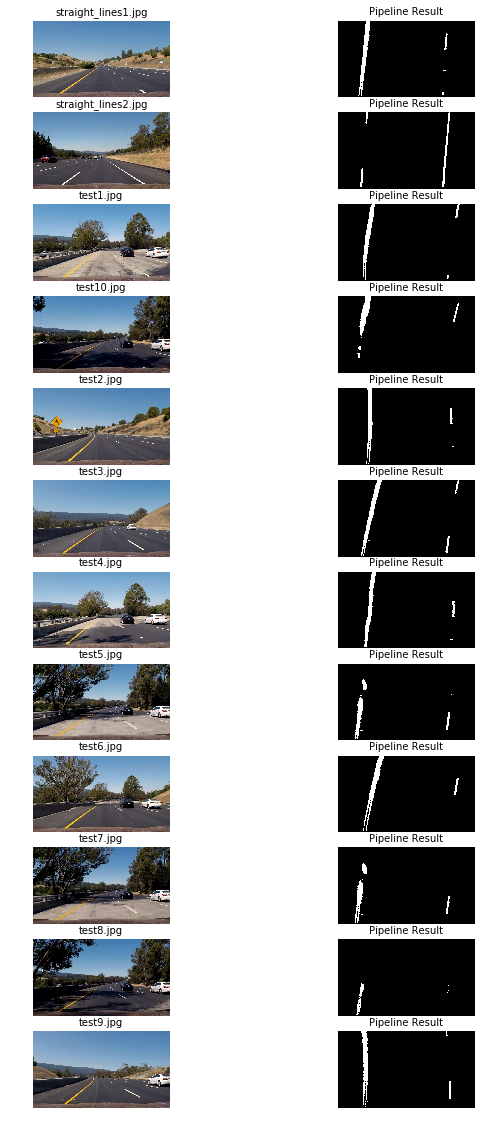

In [17]:
# Images imported from file named 'test_images'
images = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(len(images), 2, figsize=(10, 20))
axs = axs.ravel()

# Image processing
i = 0
for image in images:
    tag = image.split('/')[-1]
    test_img = cv2.imread(image)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    test_binary, undist, Minv = image_process(test_img)
    
    axs[i].imshow(test_img)
    axs[i].set_title(tag, fontsize=10)
    axs[i].axis('off')
    axs[i+1].imshow(test_binary, cmap='gray')
    axs[i+1].set_title('Pipeline Result', fontsize=10)
    axs[i+1].axis('off')
    
    i += 2

### Polynomial Curve Fitting
#### Define Class

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # Count
        self.count = 0.
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]   
        # radius of curvature of the line in some units
        self.radius_of_curvature = 0. 
        # the top point of x
        self.top = 0.
        self.bottom = 0.
        self.diff = []

#### Find the Peaks in the Histogram

In [19]:
# https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb

def find_lane_polyfit(binary_warped, left_lane, right_lane, nwindows=12, margin=50, minpix=30):
    '''
    return: out_img, arrays of lanes' indices with rectangles
    margin:  the width of the windows +/- margin
    minpix:  minimum number of pixels found to recenter window
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    

    # Left Line
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))      
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
      
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
        
    # Extract left line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]  
    
    left_fit = None
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)        
    else:
        left_fit = left_lane
        
    
    # Right Line
    
    # Current positions to be updated for each window
    rightx_current = rightx_base
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # Append these indices to the lists
        right_lane_inds.append(good_right_inds)
        
    # Concatenate the arrays of indices
    right_lane_inds = np.concatenate(right_lane_inds)  

    # Extract right line pixel positions
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if r_line.count != 0:
        np.append(rightx, [r_line.bottom, r_line.top])
        np.append(righty, [719., 0.])
    else:
        pass 
    
    right_fit = None
    # Fit a second order polynomial to each
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)        
    else:
        right_fit = right_lane
    
    return out_img, left_fit, right_fit

In [25]:
def draw_lane_line(binary_warped, undist_img, left_lane, right_lane, inv_matix, margin = 50):
    '''
    return: out_image
    '''
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_lane[0]*ploty**2 + left_lane[1]*ploty + left_lane[2]
    right_fitx = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]
   
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 7.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.5/1280 # meters per pixel in x dimension    
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_lane[0]*y_eval + left_lane[1])**2)**1.5) / np.absolute(2*left_lane[0])
    right_curverad = ((1 + (2*right_lane[0]*y_eval + right_lane[1])**2)**1.5) / np.absolute(2*right_lane[0])
  
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)  
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 

    l_line.radius_of_curvature = left_curverad
    l_line.current_fit = left_lane
    
    diff = right_fitx[0] - left_fitx[0]     
        
    # Sanity check of the right lane line
    if right_curverad/r_line.radius_of_curvature > 5 and r_line.count != 0: 
        right_lane = r_line.current_fit
        right_curverad = r_line.radius_of_curvature
        right_fitx = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]      
    elif right_curverad/r_line.radius_of_curvature < 0.2 and r_line.count != 0:
        right_lane = r_line.current_fit
        right_curverad = r_line.radius_of_curvature
        right_fitx = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]
    elif right_fitx[0] - left_fitx[0] > 900 and r_line.count != 0: 
        right_lane = r_line.current_fit
        right_curverad = r_line.radius_of_curvature
        right_fitx = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]       
    elif abs(right_curverad - r_line.radius_of_curvature) > 300 and r_line.count != 0:
        right_lane = r_line.current_fit
        right_curverad = r_line.radius_of_curvature
        right_fitx = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]   
    else:
        r_line.radius_of_curvature = right_curverad
        r_line.current_fit = right_lane 
           
    r_line.count += 1 
    
    r_line.top = right_fitx[0]
    r_line.bottom = right_fitx[-1]
    l_line.top = left_fitx[0]
    l_line.bottom = left_fitx[-1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
 
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 255, 255), thickness=15)
    
    curverad = (left_curverad + right_curverad)/2
    curvature_radius = 'Radius of curvature: %.2f m' % curverad 

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_matix, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    out_image = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)  
    
    # Calculate the distance from the center of the lane
    center_distance = (640. - ((right_fitx[0]+left_fitx[0])/2)) * xm_per_pix
    if center_distance > 0:
        center_distance_str = 'Vehicle is %.2f m right of center' % abs(center_distance)
    else: 
        center_distance_str = 'Vehicle is %.2f m left of center' % abs(center_distance)  
    
    # Add radius of curvation to the plot
    cv2.putText(out_image, curvature_radius, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

    # Add radius of curvation to the plot
    cv2.putText(out_image, center_distance_str, (100, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return out_image  

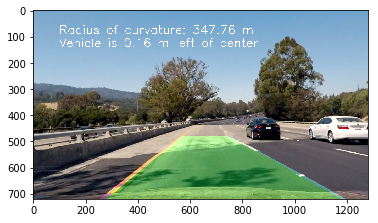

In [26]:
# Test the pipeline
input = 'test_images/test4.jpg'
img = cv2.imread(input)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
l_line = Line()
r_line = Line()
binary, undist, Minv = image_process(img)
out_img, left_fit, right_fit = find_lane_polyfit(binary, l_line.current_fit, r_line.current_fit, nwindows=12, margin=50, minpix=30)
out_image = draw_lane_line(binary, undist, left_fit, right_fit, Minv, margin = 50)
plt.imshow(out_image)

In [27]:
#-------------------------------------------------------------------------------------

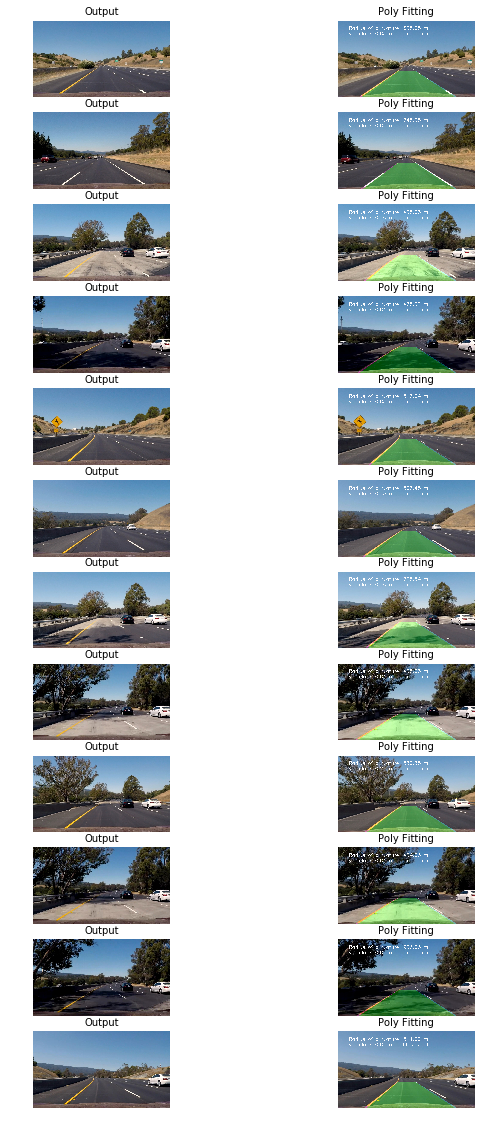

In [28]:
# Image imported
inputs = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(len(inputs), 2, figsize=(10, 20))
axs = axs.ravel()

l_line = Line()
r_line = Line()

# Image processing
i = 0
for input in inputs:
    tag = input.split('/')[-1]
    img = cv2.imread(input)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    binary, undist, Minv = image_process(img)
    out_img, left_fit, right_fit = find_lane_polyfit(binary, l_line.current_fit, r_line.current_fit, nwindows=12, margin=50, minpix=30)
    out_image = draw_lane_line(binary, undist, left_fit, right_fit, Minv, margin = 50)
    
    axs[i].imshow(img)
    axs[i].set_title(tag, fontsize=10)
    axs[i].set_title('Output', fontsize=10)
    axs[i].axis('off')
    axs[i+1].imshow(out_image) 
    axs[i+1].set_title('Poly Fitting', fontsize=10)
    axs[i+1].axis('off')
    
    i += 2

### Project Pipeline Setup

#### Define Line Class

In [29]:
def lane_line_detect(image):
   
    img = np.copy(image)
    binary, undist, Minv = image_process(img)
    out_img, left_fit, right_fit = find_lane_polyfit(binary, l_line.current_fit, r_line.current_fit, nwindows=12, margin=50, minpix=30)
    out_image = draw_lane_line(binary, undist, left_fit, right_fit, Minv, margin = 50)
    
    return out_image

In [30]:
# Image clip from the video
def extract_frames(video, times, img_dir):
    clip = VideoFileClip(video)
    for i, t in enumerate(times):
        path = img_dir+str(i)+'.jpg'
        clip.save_frame(path, t)

### Project Video Processing
#### Baseline

In [31]:
# Extract a few images from the project video
video = 'project_video.mp4'
img_dir = 'challenge_images/test'
times = np.linspace(41, 43, 25)
extract_frames(video, times, img_dir)

In [32]:
l_line = Line() 
r_line = Line()
video_output = 'project_video_test_3.mp4'
video_clip = VideoFileClip('project_video.mp4')
processed_video = video_clip.fl_image(lane_line_detect)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_test_3.mp4
[MoviePy] Writing video project_video_test_3.mp4


100%|█████████▉| 1260/1261 [03:53<00:00,  5.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_test_3.mp4 

CPU times: user 4min 19s, sys: 43.7 s, total: 5min 2s
Wall time: 3min 54s


#### Challenging

In [133]:
# Extract a few images from the challenging video
video = 'challenge_video.mp4'
img_dir = 'challenge_images/test'
times = (3.0, 5.0, 7.0, 9.0, 11.0)
extract_frames(video, times, img_dir)

In [134]:
l_line = Line() 
r_line = Line()
challenge_output = 'challenge_video_output.mp4'
challenge_clip = VideoFileClip('challenge_video.mp4')
processed_challenge = challenge_clip.fl_image(lane_line_detect)
%time processed_challenge.write_videofile(challenge_output, audio=False, fps=20)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|█████████▉| 323/324 [00:55<00:00,  5.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 3s, sys: 10.3 s, total: 1min 13s
Wall time: 56.8 s


In [24]:
l_line = Line() 
r_line = Line()
challenge_output = 'harder_challenge_video_output.mp4'
challenge_clip = VideoFileClip('harder_challenge_video.mp4')
processed_challenge = challenge_clip.fl_image(lane_line_detect)
%time processed_challenge.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:19<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 12s, sys: 13.9 s, total: 3min 26s
Wall time: 2min 21s


### Reference
https://www.intmath.com/applications-differentiation/8-radius-curvature.php